<a href="https://www.kaggle.com/code/shahar3/uw-madison-gi-tract-image-segmentation?scriptVersionId=95055985" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# UW-Madison GI Tract Image Segmentation
<br><center><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25" width=100%></center><br><center><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25" width=100%></center>
   In 2019, an estimated 5 million people were diagnosed with a cancer of the gastro-intestinal tract worldwide. Of these patients, about half are eligible for radiation therapy, usually delivered over 10-15 minutes a day for 1-6 weeks.<br>
    Radiation oncologists try to deliver high doses of radiation using X-ray beams pointed to tumors while avoiding the stomach and intestines. <br>
    With newer technology such as integrated magnetic resonance imaging and linear accelerator systems, also known as MR-Linacs, oncologists are able to visualize the daily position of the tumor and intestines, which can vary day to day. <br>
    In these scans, radiation oncologists must manually outline the position of the stomach and intestines in order to adjust the direction of the x-ray beams to increase the dose delivery to the tumor and avoid the stomach and intestines. <br>
    This is a time-consuming and labor intensive process that can prolong treatments from 15 minutes a day to an hour a day, which can be difficult for patients to tolerate—unless deep learning could help automate the segmentation process.<br>
    <br>
This notebook will run the following subjects :<br>
1. **Problem description**<br> 
    create a model to automatically segment the stomach and intestines on MRI scans.<br> 
    The MRI scans are from actual cancer patients who had 1-5 MRI scans on separate days during their radiation treatment. <br> You'll base your algorithm on a dataset of these scans to come up with creative deep learning solutions that will help cancer patients get better care.<br><br>
2. **Data gathering**<br> 
    The UW-Madison Carbone Cancer Center is a pioneer in MR-Linac based radiotherapy, and has treated patients with MRI guided radiotherapy based on their daily anatomy since 2015.<br> UW-Madison has generously agreed to support this project which provides anonymized MRIs of patients treated at the UW-Madison Carbone Cancer Center. The University of Wisconsin-Madison is a public land-grant research university in Madison, Wisconsin.<br>  The Wisconsin Idea is the university's pledge to the state, the nation, and the world that their endeavors will benefit all citizens.<br><br>
2. **EDA  - investigate the data set and visualizing the data.**
    * Plot some examples
    * Find outlinres
    * Counter plot
    * Correlation matrixs
    * PCA - https://www.youtube.com/watch?v=tU4Rm0Y_jQI <br>Maby preform the PCA after feature extraction with CNN
    * Manifold learning
    * Normelize data
    * Feature extraction 
        * Corners
        * SIFT
        * Template matching
        * Feature matching
3. **Model selection and Evaluation**<br>
    **Model selection**
    
    * Unet
    * DeepLab3
   
   **Evaluation:** <br>
   This competition is evaluated on the mean <a href="https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient"><b>Dice coefficient</b></a> and <a href="https://github.com/scipy/scipy/blob/master/scipy/spatial/_hausdorff.pyx"><b>3D Hausdorff distance</b></a>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

    $$
    \frac{2 * |X \cap Y|}{|X| + |Y|}
    $$

    where $X$ is the predicted set of pixels and $Y$ is the ground truth. 
    * The Dice coefficient is defined to be $1$ when both $X$ and $Y$ are empty. 
    * The leaderboard score is the <b>mean of the Dice coefficients for each image in the test set.</b>

    Hausdorff distance is a method for calculating the distance between segmentation objects A and B, by calculating the furthest point on object A from the nearest point on object B. For 3D Hausdorff, we construct 3D volumes by combining each 2D segmentation with slice depth as the Z coordinate and then find the Hausdorff distance between them. **(In this competition, the slice depth for all scans is set to 1.)** <a href="https://github.com/scipy/scipy/blob/master/scipy/spatial/_hausdorff.pyx"><b>The scipy code for Hausdorff is linked</b></a>. The expected / predicted pixel locations are normalized by image size to create a bounded 0-1 score.

    <br>

    ---

    <b>NOTE: The two metrics are combined during evaluation!</b>

    * <b>Weight of 0.4 for the Dice metric</b>
    * <b>Weight of 0.6 for the Hausdorff distance.</b>

    ---

    <br>

    <br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">SUBMISSION FILE INFORMATION</b>

    In order to reduce the submission file size, our metric uses **run-length encoding** on the pixel values.  
    * Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length
    * E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).
    * Note that, at the time of encoding, the mask should be **binary**
        * The masks for all objects in an image are joined into a single large mask
        * The value of **0** should indicate pixels that are not **masked**
        * The value of **1** will indicate pixels that are **masked**.

    The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

    <br>

    The file should contain a header and have the following format:

    ```
    id,class,predicted
    1,large_bowel,1 1 5 1
    1,small_bowel,1 1
    1,stomach,1 1
    2,large_bowel,1 5 2 17
    etc.
    ```


4. **Thoughts for the future.**

# Data gathering 
In this section we will import the relative libraries and obtain the dataset.
<br><br>
In this competition we are segmenting organs cells in images. The training annotations are provided as RLE-encoded masks, and the images are in 16-bit grayscale PNG format.
<br><br>
Each case in this competition is represented by multiple sets of scan slices (each set is identified by the day the scan took place). Some cases are split by time (early days are in train, later days are in test) while some cases are split by case - the entirety of the case is in train or test. The goal of this competition is to be able to generalize to both partially and wholly unseen cases.
<br><br>
Note that, in this case, the test set is entirely unseen. It is roughly 50 cases, with a varying number of days and slices, as seen in the training set.

## Segmantation RLE
RLE is run-length encoding. It is used to encode the location of foreground objects in segmentation. Instead of outputting a mask image, you give a list of start pixels and how many pixels after each of those starts is included in the mask.
<br>
The encoding rule is pretty simple: Where the mask is. Index of the mask, and how many pixels follow


<br>

## DataSet overview

### General information

<b>In this competition we are segmenting organs cells in images</b>. 

The training **annotations are provided as RLE-encoded masks**, and the images are in **16-bit**, **grayscale**, **PNG format**.

Each case in this competition is represented by multiple sets of scan slices
* Each set is identified by the day the scan took place
* Some cases are split by time
    * early days are in train
    * later days are in test
* Some cases are split by case
    * the entirety of the case is in train or test

<b>The goal of this competition is to be able to generalize to both partially and wholly unseen cases.</b>

Note that, in this case, the test set is entirely unseen.
* It is roughly 50 cases
* It contains a varying number of days and slices, (similar to the training set)

### Files imformation

**`train.csv`** 
- IDs and masks for all training objects.
- **Columns**
    * **`id`**
        * unique identifier for object
    * **`class`**
        * the predicted class for the object
    * **`EncodedPixels`**
        * RLE-encoded pixels for the identified object

<br>

**`sample_submission.csv`**
- A sample submission file in the correct format

<br>

**`train/`**
- a folder of case/day folders, each containing slice images for a particular case on a given day.

<br>

In [1]:
# Import libraries
# Operating system libraries
from glob import glob
import os
# linear algebra and data processing
import numpy as np
import pandas as pd 
# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

## Basic data definitions 

In [2]:
# Open the training dataframe and display the initial dataframe
DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)


# Get all training images
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)

print("\n... ORIGINAL TRAINING DATAFRAME... \n")
display(train_df)

TEST_DIR = os.path.join(DATA_DIR, "test")
SS_CSV   = os.path.join(DATA_DIR, "sample_submission.csv")
ss_df = pd.read_csv(SS_CSV)

# Get all testing images if there are any
all_test_images = glob(os.path.join(TEST_DIR, "**", "*.png"), recursive=True)

# For debugging purposes when the test set hasn't been substituted we will know
DEBUG=len(ss_df)==0

if DEBUG:
    TEST_DIR = TRAIN_DIR
    all_test_images = all_train_images
    ss_df = train_df.iloc[:10]
    ss_df = ss_df[["id", "class"]]
    ss_df["predicted"] = ""
    

print("\n\n\n... ORIGINAL SUBMISSION DATAFRAME... \n")    
display(ss_df)

SF2LF = {"lb":"Large Bowel","sb":"Small Bowel","st":"Stomach"}
LF2SF = {v:k for k,v in SF2LF.items()}
print(f"\n\n\n... ARE WE DEBUGGING: {DEBUG}... \n")

print("\n... BASIC DATA SETUP FINISHED ...\n\n")



... ORIGINAL TRAINING DATAFRAME... 



,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN





... ORIGINAL SUBMISSION DATAFRAME... 



,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,
5,case123_day20_slice_0002,stomach,
6,case123_day20_slice_0003,large_bowel,
7,case123_day20_slice_0003,small_bowel,
8,case123_day20_slice_0003,stomach,
9,case123_day20_slice_0004,large_bowel,





... ARE WE DEBUGGING: True... 


... BASIC DATA SETUP FINISHED ...




## Update dataframe with external information
Before we start the EDA, we will preprocess the data to create a informative dataframe with the data seperated to freatures.<br>
The feature we choose to creat from the train df are:
* Case_id
* day
* Slice_id
* file path
* Slice dimentions of the file(hight and width)<br>

The label will be changed as the following<br>
* **large_bowel** --> **lb**
* **small_bowel** --> **sb**
* **stomach** --> **st**

In [3]:
def get_filepath_from_partial_identifier(_ident, file_list):
    return [x for x in file_list if _ident in x][0]

def df_preprocessing(df, globbed_file_list, is_test=False):
    """ The preprocessing steps applied to get column information """
    # 1. Get Case-ID as a column (str and int)
    df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
    df["case_id"] = df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

    # 2. Get Day as a column
    df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
    df["day_num"] = df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))

    # 3. Get Slice Identifier as a column
    df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])

    # 4. Get full file paths for the representative scans
    df["_partial_ident"] = (globbed_file_list[0].rsplit("/", 4)[0]+"/"+ # /kaggle/input/uw-madison-gi-tract-image-segmentation/train/
                           df["case_id_str"]+"/"+ # .../case###/
                           df["case_id_str"]+"_"+df["day_num_str"]+ # .../case###_day##/
                           "/scans/"+df["slice_id"]) # .../slice_#### 
    _tmp_merge_df = pd.DataFrame({"_partial_ident":[x.rsplit("_",4)[0] for x in globbed_file_list], "f_path":globbed_file_list})
    df = df.merge(_tmp_merge_df, on="_partial_ident").drop(columns=["_partial_ident"])

    # 5. Get slice dimensions from filepath (int in pixels)
    df["slice_h"] = df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["slice_w"] = df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

    # 6. Pixel spacing from filepath (float in mm)
    df["px_spacing_h"] = df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))

    if not is_test:
        # 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
        l_bowel_df = df[df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
        s_bowel_df = df[df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
        stomach_df = df[df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
        df = df.merge(l_bowel_df, on="id", how="left")
        df = df.merge(s_bowel_df, on="id", how="left")
        df = df.merge(stomach_df, on="id", how="left")
        df = df.drop_duplicates(subset=["id",]).reset_index(drop=True)
        df["lb_seg_flag"] = df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
        df["sb_seg_flag"] = df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
        df["st_seg_flag"] = df["st_seg_rle"].apply(lambda x: not pd.isna(x))
        df["n_segs"] = df["lb_seg_flag"].astype(int)+df["sb_seg_flag"].astype(int)+df["st_seg_flag"].astype(int)

    # 8. Reorder columns to the a new ordering (drops class and segmentation as no longer necessary)
    new_col_order = ["id", "f_path", "n_segs",
                     "lb_seg_rle", "lb_seg_flag",
                     "sb_seg_rle", "sb_seg_flag", 
                     "st_seg_rle", "st_seg_flag",
                     "slice_h", "slice_w", "px_spacing_h", 
                     "px_spacing_w", "case_id_str", "case_id", 
                     "day_num_str", "day_num", "slice_id",]
    if is_test: new_col_order.insert(1, "class")
    new_col_order = [_c for _c in new_col_order if _c in df.columns]
    df = df[new_col_order]
    
    return df
df = df_preprocessing(train_df,all_train_images)

In [4]:
print("\n... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION STARTED ...\n\n")

# 1. Get Case-ID as a column (str and int)
train_df["case_id_str"] = train_df["id"].apply(lambda x: x.split("_", 2)[0])
train_df["case_id"] = train_df["id"].apply(lambda x: int(x.split("_", 2)[0].replace("case", "")))

# 2. Get Day as a column
train_df["day_num_str"] = train_df["id"].apply(lambda x: x.split("_", 2)[1])
train_df["day_num"] = train_df["id"].apply(lambda x: int(x.split("_", 2)[1].replace("day", "")))

# 3. Get Slice Identifier as a column
train_df["slice_id"] = train_df["id"].apply(lambda x: x.split("_", 2)[2])

# 4. Get full file paths for the representative scans
train_df["_partial_ident"] = (TRAIN_DIR+"/"+ # /kaggle/input/uw-madison-gi-tract-image-segmentation/train/
                             train_df["case_id_str"]+"/"+ # .../case###/
                             train_df["case_id_str"]+"_"+train_df["day_num_str"]+ # .../case###_day##/
                             "/scans/"+train_df["slice_id"]) # .../slice_#### 
_tmp_merge_df = pd.DataFrame({"_partial_ident":[x.rsplit("_",4)[0] for x in all_train_images], "f_path":all_train_images})
train_df = train_df.merge(_tmp_merge_df, on="_partial_ident").drop(columns=["_partial_ident"])

# Minor cleanup of our temporary workaround
del _tmp_merge_df###########################******

# 5. Get slice dimensions from filepath (int in pixels)
train_df["slice_h"] = train_df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
train_df["slice_w"] = train_df["f_path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

# 6. Pixel spacing from filepath (float in mm)
train_df["px_spacing_h"] = train_df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
train_df["px_spacing_w"] = train_df["f_path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))

# 7. Merge 3 Rows Into A Single Row (As This/Segmentation-RLE Is The Only Unique Information Across Those Rows)
l_bowel_train_df = train_df[train_df["class"]=="large_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"lb_seg_rle"})
s_bowel_train_df = train_df[train_df["class"]=="small_bowel"][["id", "segmentation"]].rename(columns={"segmentation":"sb_seg_rle"})
stomach_train_df = train_df[train_df["class"]=="stomach"][["id", "segmentation"]].rename(columns={"segmentation":"st_seg_rle"})
train_df = train_df.merge(l_bowel_train_df, on="id", how="left")
train_df = train_df.merge(s_bowel_train_df, on="id", how="left")
train_df = train_df.merge(stomach_train_df, on="id", how="left")
train_df = train_df.drop_duplicates(subset=["id",]).reset_index(drop=True)
train_df["lb_seg_flag"] = train_df["lb_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["sb_seg_flag"] = train_df["sb_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["st_seg_flag"] = train_df["st_seg_rle"].apply(lambda x: not pd.isna(x))
train_df["n_segs"] = train_df["lb_seg_flag"].astype(int)+train_df["sb_seg_flag"].astype(int)+train_df["st_seg_flag"].astype(int)

# 8. Reorder columns to the a new ordering (drops class and segmentation as no longer necessary)
train_df = train_df[["id", "f_path", "n_segs",
                     "lb_seg_rle", "lb_seg_flag",
                     "sb_seg_rle", "sb_seg_flag", 
                     "st_seg_rle", "st_seg_flag",
                     "slice_h", "slice_w", "px_spacing_h", 
                     "px_spacing_w", "case_id_str", "case_id", 
                     "day_num_str", "day_num", "slice_id",]]

# 9. Display update dataframe
print("\n... UPDATED TRAINING DATAFRAME... \n")
display(train_df)

ss_df = df_preprocessing(ss_df, all_test_images, is_test=True)
print("\n\n\n... UPDATED SUBMISSION DATAFRAME... \n")
display(ss_df)

print("\n... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION FINISHED ...\n\n")


... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION STARTED ...



... UPDATED TRAINING DATAFRAME... 



,id,f_path,n_segs,lb_seg_rle,lb_seg_flag,sb_seg_rle,sb_seg_flag,st_seg_rle,st_seg_flag,slice_h,slice_w,px_spacing_h,px_spacing_w,case_id_str,case_id,day_num_str,day_num,slice_id
0,case123_day20_slice_0001,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0001
1,case123_day20_slice_0002,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0002
2,case123_day20_slice_0003,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0003
3,case123_day20_slice_0004,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0004
4,case123_day20_slice_0005,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case123,123,day20,20,slice_0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0140
38492,case30_day0_slice_0141,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0141
38493,case30_day0_slice_0142,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0142
38494,case30_day0_slice_0143,/kaggle/input/uw-madison-gi-tract-image-segmen...,0,NaN,False,NaN,False,NaN,False,266,266,1.5,1.5,case30,30,day0,0,slice_0143





... UPDATED SUBMISSION DATAFRAME... 



,id,class,f_path,slice_h,slice_w,px_spacing_h,px_spacing_w,case_id_str,case_id,day_num_str,day_num,slice_id
0,case123_day20_slice_0001,large_bowel,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0001
1,case123_day20_slice_0001,small_bowel,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0001
2,case123_day20_slice_0001,stomach,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0001
3,case123_day20_slice_0002,large_bowel,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0002
4,case123_day20_slice_0002,small_bowel,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0002
5,case123_day20_slice_0002,stomach,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0002
6,case123_day20_slice_0003,large_bowel,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0003
7,case123_day20_slice_0003,small_bowel,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0003
8,case123_day20_slice_0003,stomach,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0003
9,case123_day20_slice_0004,large_bowel,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,1.5,1.5,case123,123,day20,20,slice_0004



... UPDATING DATAFRAMES WITH ACCESSIBLE INFORMATION FINISHED ...




# EDA

## Helper functions
Before we start the data observation, we will need some functions to decode and encode the segmantation masks

In [5]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

# https://www.kaggle.com/namgalielei/which-reshape-is-used-in-rle
def rle_decode_top_to_bot_first(mask_rle, shape):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns:
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0]), order='F').T  # Reshape from top -> bottom first

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path):
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def tf_load_png(img_path):
    return tf.image.decode_png(tf.io.read_file(img_path), channels=3)

def open_gray16(_path, normalize=True, to_rgb=False):
    """ Helper to open files """
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)


## Exploring tha dataset
After preprocessing the multiple datasets and adding feature to investigate, now we can start exploring the data.

In [6]:
def get_overlay(img_path, rle_strs, img_shape, _alpha=0.999, _beta=0.35, _gamma=0):
    _img = open_gray16(img_path, to_rgb=True)
    _img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
    _seg_rgb = np.stack([rle_decode(rle_str, shape=img_shape, color=1) if rle_str is not None else np.zeros(img_shape, dtype=np.float32) for rle_str in rle_strs], axis=-1).astype(np.float32)
    seg_overlay = cv2.addWeighted(src1=_img, alpha=_alpha, 
                                  src2=_seg_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def examine_id(ex_id, df=train_df, plot_overlay=True, print_meta=False, plot_grayscale=False, plot_binary_segmentation=False):
    """ Wrapper function to allow for easy visual exploration of an example """
    print(f"\n... ID ({ex_id}) EXPLORATION STARTED ...\n\n")
    demo_ex = df[df.id==ex_id].squeeze()

    if print_meta:
        print(f"\n... WITH DEMO_ID=`{DEMO_ID}` WE HAVE THE FOLLOWING DEMO EXAMPLE TO WORK FROM... \n\n")
        display(demo_ex.to_frame())

    if plot_grayscale:
        print(f"\n\n... GRAYSCALE IMAGE PLOT ...\n")
        plt.figure(figsize=(12,12))
        plt.imshow(open_gray16(demo_ex.f_path), cmap="gray")
        plt.title(f"Original Grayscale Image For ID: {demo_ex.id}", fontweight="bold")
        plt.axis(False)
        plt.show()

    if plot_binary_segmentation:
        print(f"\n\n... BINARY SEGMENTATION MASKS ...\n")
        plt.figure(figsize=(20,10))
        for i, _seg_type in enumerate(["lb", "sb", "st"]):
            if pd.isna(demo_ex[f"{_seg_type}_seg_rle"]): continue
            plt.subplot(1,3,i+1)
            plt.imshow(rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1))
            plt.title(f"RLE Encoding For {SF2LF[_seg_type]} Segmentation", fontweight="bold")
            plt.axis(False)
        plt.tight_layout()
        plt.show()

    if plot_overlay:
        print(f"\n\n... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...\n")
        # We need to normalize the loaded image values to be between 0 and 1 or else our plot will look weird
        # _img = open_gray16(demo_ex.f_path, to_rgb=True)
        #_img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
        #_seg_rgb = np.stack([rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1) if not pd.isna(demo_ex[f"{_seg_type}_seg_rle"]) else np.zeros((demo_ex.slice_w, demo_ex.slice_h)) for _seg_type in ["lb", "sb", "st"]], axis=-1).astype(np.float32)
        #seg_overlay = cv2.addWeighted(src1=_img, alpha=0.99, 
                                      #src2=_seg_rgb, beta=0.33, gamma=0)
        _rle_strs = [demo_ex[f"{_seg_type}_seg_rle"] if not pd.isna(demo_ex[f"{_seg_type}_seg_rle"]) else None for _seg_type in ["lb", "sb", "st"]]
        seg_overlay = get_overlay(demo_ex.f_path, _rle_strs, img_shape=(demo_ex.slice_w, demo_ex.slice_h))

        plt.figure(figsize=(12,12))
        plt.imshow(seg_overlay)
        plt.title(f"Segmentation Overlay For ID: {demo_ex.id}", fontweight="bold")
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
        plt.legend(handles,labels)
        plt.axis(False)
        plt.show()

    print("\n\n... SINGLE ID EXPLORATION FINISHED ...\n\n")


... SINGLE ID EXPLORATION STARTED ...



... WITH DEMO_ID=`case123_day20_slice_0082` WE HAVE THE FOLLOWING DEMO EXAMPLE TO WORK FROM... 




,81
id,case123_day20_slice_0082
f_path,/kaggle/input/uw-madison-gi-tract-image-segmen...
n_segs,3
lb_seg_rle,17481 4 17746 7 18010 10 18275 12 18539 14 188...
lb_seg_flag,True
sb_seg_rle,22236 2 22500 6 22765 8 23030 10 23296 10 2356...
sb_seg_flag,True
st_seg_rle,11052 8 11314 15 11578 19 11843 23 12108 26 12...
st_seg_flag,True
slice_h,266




... LET'S PLOT THE IMAGE FIRST ...



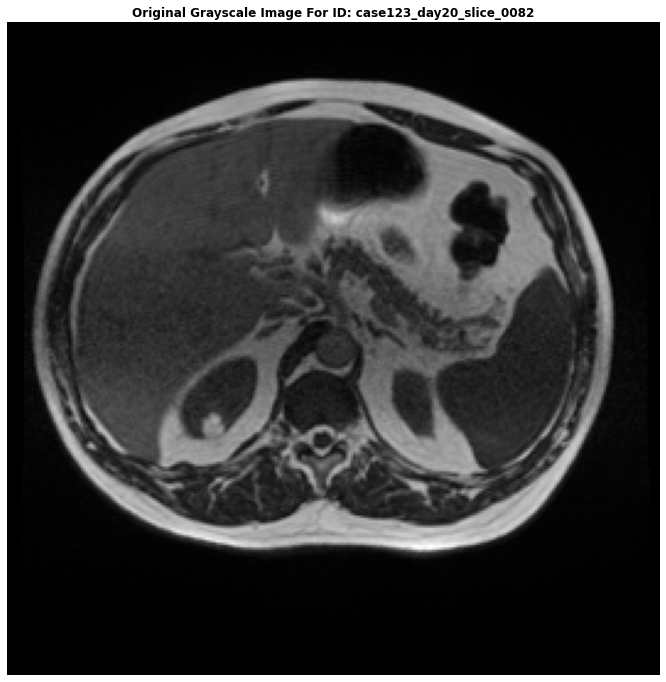



... LET'S PLOT THE 3 SEGMENTATION MASKS ...



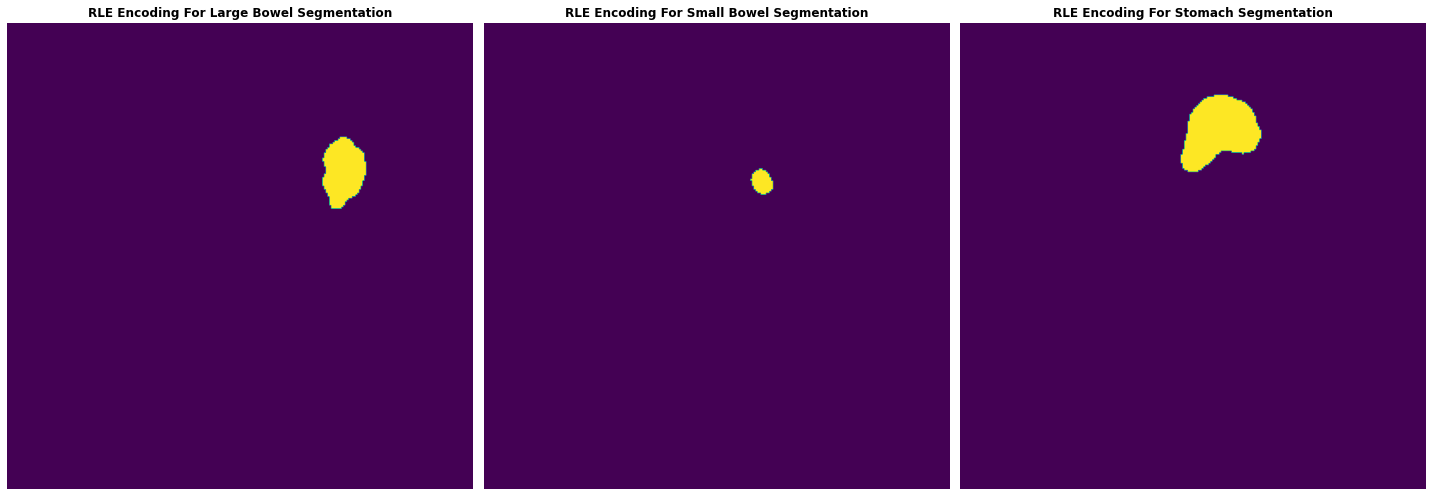



... LET'S PLOT THE IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...



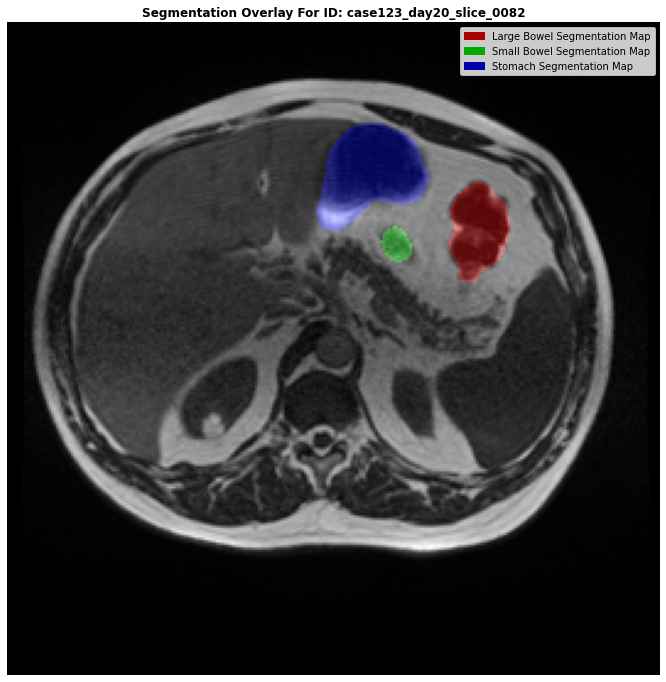



... LET'S PRINT THE RELEVANT INFORMATION ...

	--> IMAGE CASE ID              : 123
	--> IMAGE DAY NUMBER           : 20
	--> IMAGE SLICE WIDTH          : 266
	--> IMAGE SLICE HEIGHT         : 266
	--> IMAGE PIXEL SPACING WIDTH  : 1.5
	--> IMAGE PIXEL SPACING HEIGHT : 1.5


... SINGLE ID EXPLORATION FINISHED ...




In [7]:
print("\n... SINGLE ID EXPLORATION STARTED ...\n\n")

DEMO_ID = "case123_day20_slice_0082"
demo_ex = train_df[train_df.id==DEMO_ID].squeeze() # change dimentions from 1,18 to 18

print(f"\n... WITH DEMO_ID=`{DEMO_ID}` WE HAVE THE FOLLOWING DEMO EXAMPLE TO WORK FROM... \n\n")
display(demo_ex.to_frame()) #Convert Series to DataFrame.

print(f"\n\n... LET'S PLOT THE IMAGE FIRST ...\n")
plt.figure(figsize=(12,12))
plt.imshow(open_gray16(demo_ex.f_path), cmap="gray")
plt.title(f"Original Grayscale Image For ID: {demo_ex.id}", fontweight="bold")
plt.axis(False)
plt.show()

print(f"\n\n... LET'S PLOT THE 3 SEGMENTATION MASKS ...\n")

plt.figure(figsize=(20,10))
for i, _seg_type in enumerate(["lb", "sb", "st"]):
    if pd.isna(demo_ex[f"{_seg_type}_seg_rle"]): continue
    plt.subplot(1,3,i+1)
    plt.imshow(rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1))
    plt.title(f"RLE Encoding For {SF2LF[_seg_type]} Segmentation", fontweight="bold")
    plt.axis(False)
plt.tight_layout()
plt.show()

print(f"\n\n... LET'S PLOT THE IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...\n")

# We need to normalize the loaded image values to be between 0 and 1 or else our plot will look weird
_img = open_gray16(demo_ex.f_path, to_rgb=True)
_img = ((_img-_img.min())/(_img.max()-_img.min())).astype(np.float32)
_seg_rgb = np.stack([rle_decode(demo_ex[f"{_seg_type}_seg_rle"], shape=(demo_ex.slice_w, demo_ex.slice_h), color=1) if not pd.isna(demo_ex[f"{_seg_type}_seg_rle"]) else np.zeros((demo_ex.slice_w, demo_ex.slice_h)) for _seg_type in ["lb", "sb", "st"]], axis=-1).astype(np.float32)
seg_overlay = cv2.addWeighted(src1=_img, alpha=0.99, 
                              src2=_seg_rgb, beta=0.33, gamma=0.0)

plt.figure(figsize=(12,12))
plt.imshow(seg_overlay)
plt.title(f"Segmentation Overlay For ID: {demo_ex.id}", fontweight="bold")
handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
plt.legend(handles,labels)
plt.axis(False)
plt.show()

print(f"\n\n... LET'S PRINT THE RELEVANT INFORMATION ...\n")
print(f"\t--> IMAGE CASE ID              : {demo_ex.case_id}")
print(f"\t--> IMAGE DAY NUMBER           : {demo_ex.day_num}")
print(f"\t--> IMAGE SLICE WIDTH          : {demo_ex.slice_w}")
print(f"\t--> IMAGE SLICE HEIGHT         : {demo_ex.slice_h}")
print(f"\t--> IMAGE PIXEL SPACING WIDTH  : {demo_ex.px_spacing_w}")
print(f"\t--> IMAGE PIXEL SPACING HEIGHT : {demo_ex.px_spacing_h}")

print("\n\n... SINGLE ID EXPLORATION FINISHED ...\n\n")

As we can see there are 33913 images with segmantation masks<br>


... ID (case40_day17_slice_0087) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



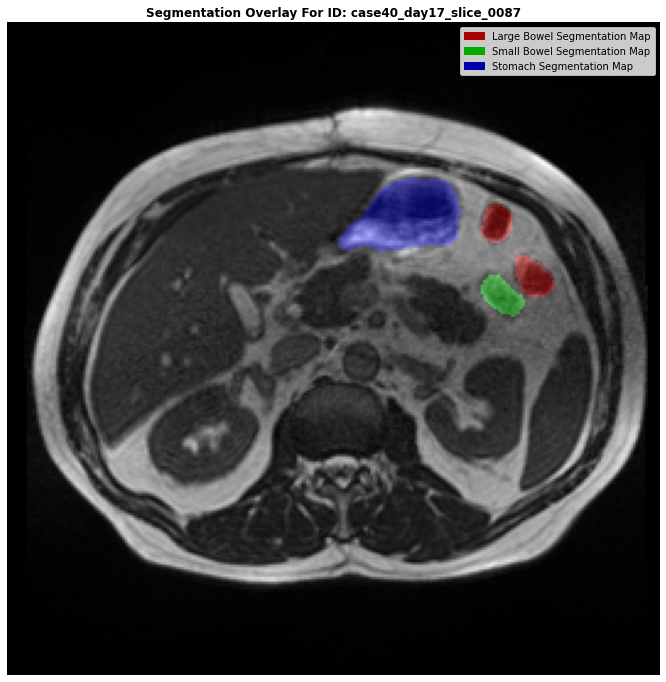



... SINGLE ID EXPLORATION FINISHED ...



... ID (case66_day0_slice_0076) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



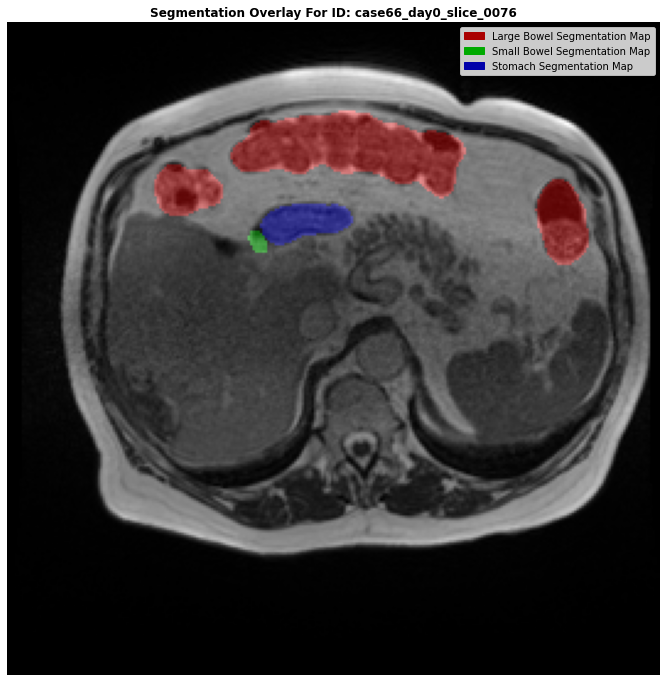



... SINGLE ID EXPLORATION FINISHED ...



... ID (case6_day24_slice_0075) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



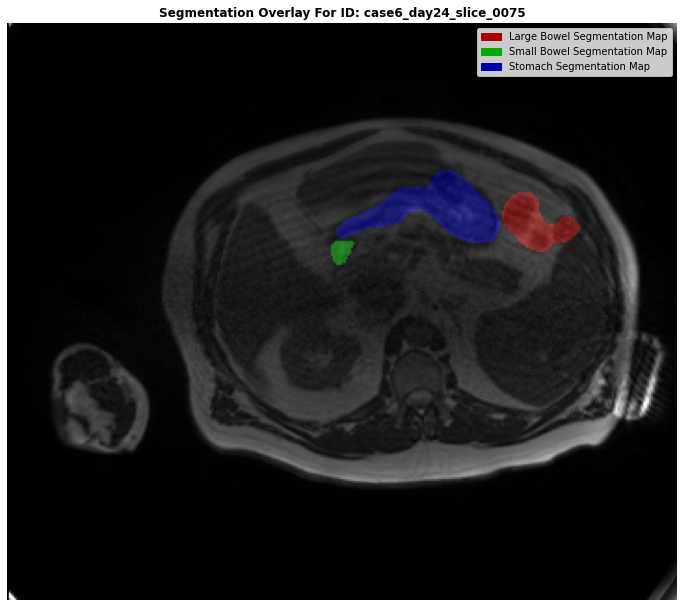



... SINGLE ID EXPLORATION FINISHED ...



... ID (case118_day0_slice_0037) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



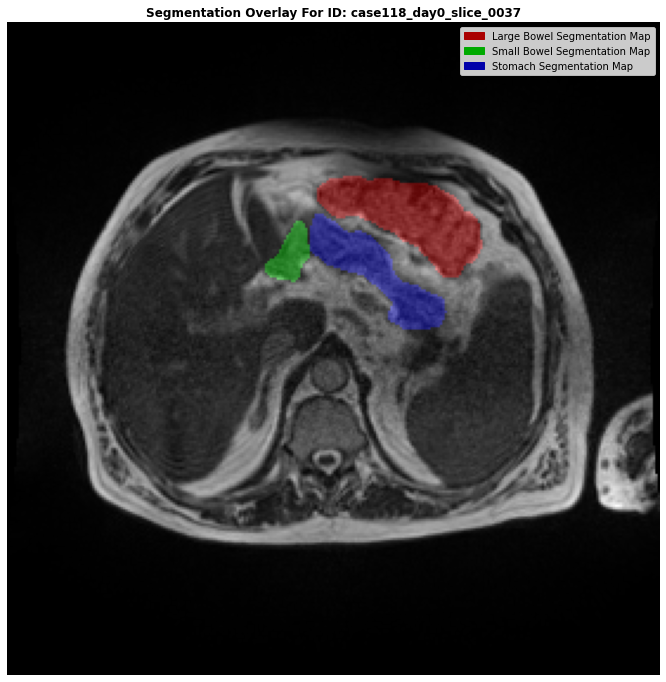



... SINGLE ID EXPLORATION FINISHED ...



... ID (case147_day18_slice_0075) EXPLORATION STARTED ...




... IMAGE WITH RGB SEGMENTATION MASK OVERLAY ...



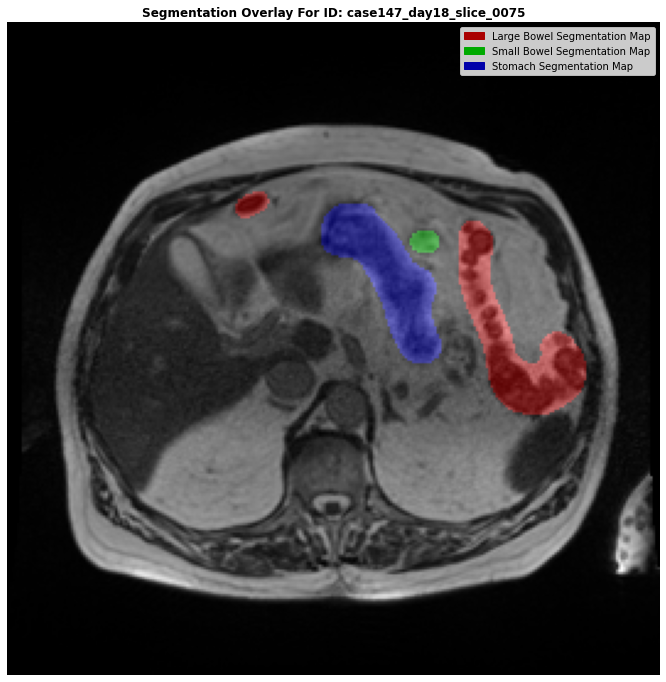



... SINGLE ID EXPLORATION FINISHED ...




In [8]:
# Plot 5 random-ids where all tumor locales are present (max one id per case)
N_TO_PLOT = 5
for _id in train_df[train_df.n_segs==3].groupby("case_id")["id"].first().sample(N_TO_PLOT):
    examine_id(_id)

### Investigate the segmantation 
The counter plot can show us that most of the images have larg bowel segmantation mask, and less cases of stomach and small bowel cases.<br>
Each case contaion 3 masks of segmantataion, lets check how many cases have no segmantation masks

In [9]:
print("Total number of images : ",train_df.shape[0])
no_ann_df = train_df[~train_df['lb_seg_flag']&~train_df['sb_seg_flag']&~train_df['st_seg_flag']]
print("Number of images without any annotation : ",no_ann_df.shape[0],"precentege : ",
      round(no_ann_df.shape[0]/train_df.shape[0],2))
print("Number of images with 1 annotation or more : ",
      (train_df.shape[0]-no_ann_df.shape[0]),"precentege : ",
      round((train_df.shape[0]-no_ann_df.shape[0])/train_df.shape[0],2))
print("Number of Stomach annotation: ",train_df[train_df['st_seg_flag']].shape[0])
print("Number of Small bowel annotation: ",train_df[train_df['sb_seg_flag']].shape[0])
print("Number of Large bowel annotation: ",train_df[train_df['lb_seg_flag']].shape[0])

Total number of images :  38496
Number of images without any annotation :  21906 precentege :  0.57
Number of images with 1 annotation or more :  16590 precentege :  0.43
Number of Stomach annotation:  8627
Number of Small bowel annotation:  11201
Number of Large bowel annotation:  14085


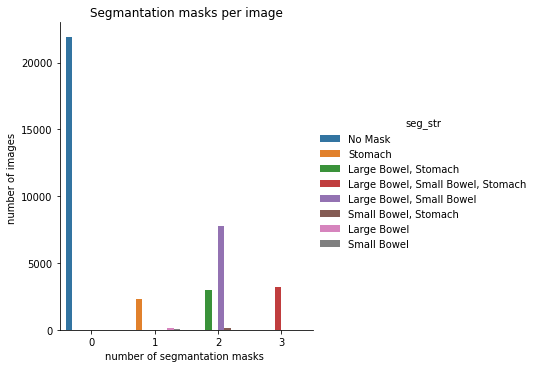

In [10]:
def add_seg_str(x):
    list_seg = []
    if x["lb_seg_flag"]: list_seg.append("Large Bowel")
    if x["sb_seg_flag"]: list_seg.append("Small Bowel")
    if x["st_seg_flag"]: list_seg.append("Stomach")
    if len(list_seg)>0:
        return ", ".join(list_seg)
    else:
        return "No Mask"
train_df["seg_str"] = train_df.apply(add_seg_str, axis=1)
fig = sns.catplot(x="n_segs", kind="count",hue = 'seg_str', data=train_df).set(title = 'Segmantation masks per image')
fig.set_xlabels("number of segmantation masks ")
fig.set_ylabels("number of images ")

From the observation we can lean that,<br>
Most of the cases that have only 1 segmantation mask is the **Stomach**.<br>
Images that has Small bowel segmantation mask usualy has large bowel segmantation mask.<br>
As we saw from the previous cell, most of the masks don't have any segmantation mask. <br>
Let's plot without the images without mask to see the distrebution of the annotation.


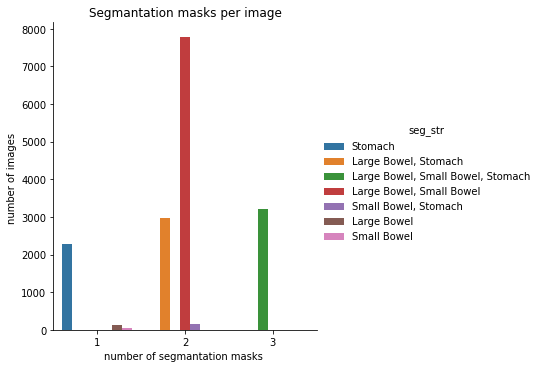

In [11]:
fig = sns.catplot(x="n_segs", kind="count",hue = 'seg_str', data=train_df[train_df['n_segs']>0]).set(title = 'Segmantation masks per image')
fig.set_xlabels("number of segmantation masks ")
fig.set_ylabels("number of images ")

It is clear now that most of the images with 2 segmantation masks are Large Bowel and Small Bowel.
Lets investigate the images with only 1 annotation

Text(0.5, 1.0, 'Only 1 mask of segmantation')

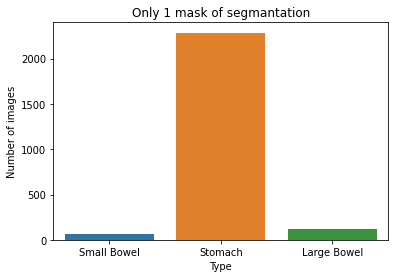

In [12]:
n_sb = train_df[(train_df['seg_str']=='Small Bowel') &( train_df['n_segs'] == 1)].shape[0]
n_st = train_df[(train_df['seg_str']=='Stomach') &( train_df['n_segs'] == 1)].shape[0]
n_lb = train_df[(train_df['seg_str']=='Large Bowel') &( train_df['n_segs'] == 1)].shape[0]
bar_df = pd.DataFrame([['Small Bowel',n_sb],['Stomach',n_st],['Large Bowel',n_lb]],columns=['Type','Number of images'])
sns.barplot(x="Type", y="Number of images", data=bar_df).set_title("Only 1 mask of segmantation")

Now we can see clearly that the vast majority of images that has 1 segmantation mask are stomach

## Image size 
After exploring the segmantation masks, lets start investigation on the image sizes